# Zillow Data Final Report   

# Zachary Stufflebeme

In [1]:
from grab_db import my_db
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from zillow_wrangle import my_train_test_split, clean_zillow, plot_variable_pairs, plot_categorical_and_continuous_vars, get_zillow_data, scale_zillow
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from evaluate import plot_residuals, regression_errors, baseline_mean_errors, better_than_baseline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

# My Plan:

Aquire: acquire data through functions saved in my acquire.py along with my encrypted credentials.

Prepare: Prepare and clean my data in such a way that I can plug it in to my Regression models without causing error and with the prepared data still holding true to its original meaning.

Explore: Ask statistical questions of my data and create visualizations of the results in order to improve comprehension by people reading the report without clarifications from my presentation.

Model:Create models and adjust parameters to try to closely predict house prices, Validate that all of your models are accurate not just on your train data but on outside data as well.

Deliver: Put all of my findings together in a final report where I make things as easy to understand as possible.


# Project Summary:

.In my project I was able to create 3 models That all performed similarly well and above the baseline I used bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, poolcnt, and age. My polynomial model was my best model as it had the lowest RMSE on train and validate. 

# Acquire Data:

Most of the work here has already been taken care of in my acquire.py

In [2]:
zillow = get_zillow_data()

In [3]:
zillow.head()

,Unnamed: 0,taxvaluedollarcnt,fips,yearbuilt,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,garagecarcnt,lotsizesquarefeet,poolcnt,regionidzip,roomcnt,numberofstories
0,0,1023282.0,6059.0,1998.0,4.0,3.5,3100.0,2.0,4506.0,NaN,96978.0,0.0,NaN
1,1,464000.0,6111.0,1967.0,2.0,1.0,1465.0,1.0,12647.0,NaN,97099.0,5.0,1.0
2,2,564778.0,6059.0,1962.0,3.0,2.0,1243.0,2.0,8432.0,1.0,97078.0,6.0,1.0
3,3,145143.0,6037.0,1970.0,4.0,3.0,2376.0,NaN,13038.0,1.0,96330.0,0.0,NaN
4,4,773303.0,6037.0,1950.0,4.0,3.0,2962.0,NaN,63000.0,1.0,96293.0,0.0,NaN


This is the way the dataframe is formatted before I make any changes. I retrieved the data from our SQL database using my encrypted credentials from my env file. The data is not formatted very well for me to use our regression models and I will have to make a lot of changes.

# Prepare Data:

In [4]:
# Here I am running the previous df through my prepare functions i created in my prepare.py
zillow = clean_zillow(zillow)

In [5]:
#this is calling the dataframe I've just run through prepare
#This is how I have chosen to get rid of outliers that ruin the score of my model.
#I have cut out houses that are above the price of 2 million dollars.
zillow = zillow[zillow['taxvaluedollarcnt'] < 2000000]

As you can see I have made a lot of changes to the data within my prepare.py in order for it to be formatted in a way that works with the different ML models I will be creating.

Preperation is where I found myself spending most of my time as the Zillow data was not perfect for model creation. I will try and briefly summarize what I did: 

- deleted all columns filled with duplicate values to get rid of unnecessary features.
- tried to impute different missing values using logic where possible.
- create a function to scale all values other than my target between 0 and 1 to better fit my data
- made new encoded columns of my categorical variables to use them in my models.
- drop all of the old columns I just encoded 
-  fix muddy data such as nulls that were appearing in certain places which was linked to weather or not they had structures built on the property or not

# Splitting data

In [6]:
#calling my split data function from my prepare in order to have training, validating, and testing portions of my data.
train, validate, test = my_train_test_split(zillow)
train, validate, test = my_train_test_split(zillow)
x_train = train.drop(columns = 'taxvaluedollarcnt')
y_train = train.taxvaluedollarcnt
x_validate = validate.drop(columns = 'taxvaluedollarcnt')
y_validate = validate.taxvaluedollarcnt
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
x_test = test.drop(columns = 'taxvaluedollarcnt')
y_test = test.taxvaluedollarcnt
y_test = pd.DataFrame(y_test)

# Data Exploration:

alpha = .05

QUESTION 1: Is bedroom count correlated to house price?

- Hnull - bedroomcnt is not correlated with taxvaluedollarcnt.

- Halt - bedroomcnt is correlated with taxvaluedollarcnt

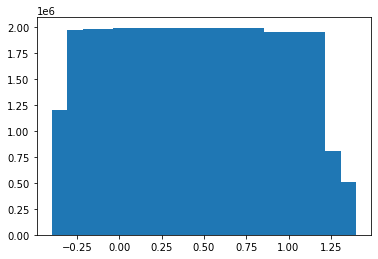

In [7]:
#Here I am creating the visualization you see below
plt.bar(train.bedroomcnt,train.taxvaluedollarcnt)
plt.show()

In [21]:
#Here I am running a correlation test on bedroom count and house price.
corr, p = spearmanr(train.bedroomcnt, train.taxvaluedollarcnt)
corr, p


(0.27277618491646816, 0.0)

Since my p-val is less than .05 I can reject the null hypothesis that there is no correlation between bedroom count and house price. The .27 as my corr value indicates that the correlation is positive but weak. However it still could be a useful feature for my model.

QUESTION 2: Is bathroom count correlated to house price?

- Hnull - bathroom count is not correlated to house price.


- Halt - bathroom count is correlated to house price


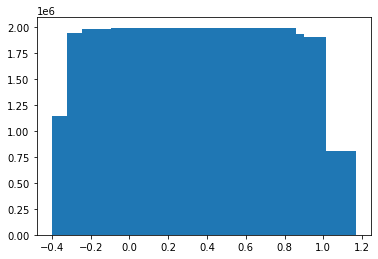

In [9]:
#here I am creating the visualization you see below
plt.bar(train.bathroomcnt,train.taxvaluedollarcnt)
plt.show()

In [23]:
#Here I am running a correlation test on bathroom count and house price.
corr, p = spearmanr(train.bathroomcnt, train.taxvaluedollarcnt)
corr, p


(0.4578625198588518, 0.0)

Since the p-val is less than alpha we can reject the null hypothesis that bathroom count is not correlated to house price. Since my correlation value is around .45 the correlation is positive and moderate in strength.

This means that Using bathroom count could be useful for our modeling.


QUESTION 3: Is square feet correlated with house price?

- Hnull - square feet is not correlated with house price.

- Halt - square feet is correlated with house price.

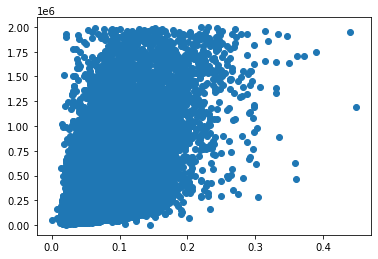

In [11]:
#Here I am creating the visualization you see below
plt.scatter(train.calculatedfinishedsquarefeet,train.taxvaluedollarcnt)

In [12]:
# Here I am running a correlation test on square feet and house price.
corr, p = pearsonr(train.calculatedfinishedsquarefeet, train.taxvaluedollarcnt)
corr, p


(0.5756816296036781, 0.0)

Since the p-val is less than alpha we can reject the null hypothesis and can conclude that square feet and house price are positivelhy correlated with moderate strength. This mens square feet could be a useful feature for modeling.

Question 4: is house age correlated to house price?

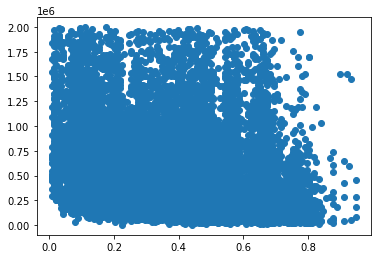

In [13]:
#Here is the code for the visual below
plt.scatter(train.age,train.taxvaluedollarcnt)
plt.show()

In [14]:
#Here is a correlation test on house age and house price
corr, p = pearsonr(train.age,train.taxvaluedollarcnt)
corr, p

(-0.25099832014569856, 0.0)

since my p is less than alpha I can reject the null hypothesis. This means there is a correlation between age and house price that is negativ and somewhat weak in strength. However this correlation could still prove useful for my model.

IMPORTANT FINDINGS FROM EXPLORATION:

- Bedroom count is positively correlated to my target and is useful for modeling
- Bathroom count is positively correlated to my target and is useful for modeling
- Square feet is positively correlated to my target and is useful for modeling
- house age is negatively correlated to my targer and is useful for modeling

# Models and Evaluation:

Models I will make:

- LassoLars

- TweedieRegressor

- Polynomial

I found the most success using bedroomcnt, bathroomcnt, square feet, poolcnt, and house age.

RMSE using Mean
Train/In-Sample:  352200.76 
Validate/Out-of-Sample:  358833.99

-------------------------------------------------------------Lasso/Lars---------------------------------------------------------------------------------

In [15]:
#This is where I create my Lasso Lars model
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model 

lars.fit(x_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxval_pred_lars'] = lars.predict(x_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxval_pred_lars)**(1/2)

# predict validate
y_validate['taxval_pred_lars'] = lars.predict(x_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train,
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lasso + Lars
Training/In-Sample:  281339.4570491243 
Validation/Out-of-Sample:  288485.4203244481


As you can see we have already validated above the baseline! This is great news but lets keep digging into other models.

------------------------------------------------------------TweedieRegressor------------------------------------------------------------------------------------------

In [16]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train,
# since we have converted it to a dataframe from a series!
glm.fit(x_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxval_pred_glm'] = glm.predict(x_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxval_pred_glm)**(1/2)

# predict validate
y_validate['taxval_pred_glm'] = glm.predict(x_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train,
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  294630.9767196031 
Validation/Out-of-Sample:  329772.1033439407


above is how we score on validate

Here I am scoring an RMSE extremely similar to the baseline therefor this model wont be  very useful going forward as it has already performed worse than my first model

------------------------------------------------------------Polynomial------------------------------------------------------------------------------------------

In [17]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
x_train_degree2 = pf.fit_transform(x_train)

# transform X_validate_scaled & X_test_scaled
x_validate_degree2 = pf.transform(x_validate)
x_test_degree2 = pf.transform(x_test)


In [18]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train,
# since we have converted it to a dataframe from a series!
lm2.fit(x_train_degree2, y_train.taxvaluedollarcnt)

# predict train
y_train['taxval_pred_lm2'] = lm2.predict(x_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxval_pred_lm2)**(1/2)

# predict validate
y_validate['taxval_pred_lm2'] = lm2.predict(x_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train,
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  275775.101445778 
Validation/Out-of-Sample:  281584.4785686004


This is the best results of all of my models therefor this is the one I will use going forward.

IMPORTANT FINDINGS FROM EVALUATION:

- I was able to create 3 models that are training and validating above or around the baseline
- My best performing model is my polynomial model validating at an RMSE of 281607.03250049026

# Testing best model:

Lets test the best model against unseen data.

In [19]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
x_train_degree2 = pf.fit_transform(x_train)

# transform X_validate_scaled & X_test_scaled
x_validate_degree2 = pf.transform(x_validate)
x_test_degree2 = pf.transform(x_test)

In [20]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train,
# since we have converted it to a dataframe from a series!
lm2.fit(x_train_degree2, y_train.taxvaluedollarcnt)

# predict test
y_test['taxval_pred_lm2'] = lm2.predict(x_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxvaluedollarcnt, y_test.taxval_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTest/Out-of-Sample: ", rmse_test)


RMSE for Polynomial Model, degrees=2
Test/Out-of-Sample:  280758.8617654899


As you can see We are  testing at an RMSE of 280758.86  which is 70,000 lower than our baseline.

# Conclusion:

In conclusion I found some important features to look at moving forward as well as made a good start on creating a model that can closely predict house prices. In the future I would like to experiment a little more with my feature engineering and find a way to include more data that can further reduce my errors. It would also be a good idea to make another model for houses above my cutoff of 2 million dollars.

# Business Reccomendation : 

Since I was a able to close the gap of or errors significantly from the baseline I think that it would be very benificial to allow me more time to continue improving upon my model to help more accurate predict house prices. but for the time being I think that using my model for predicting house prices would help us evaluate houses more accurately.